<div class="alert alert-block alert-success" style="font-size: 24px; font-weight: bold; text-align: center; margin-bottom: 0;">
    Solar Forecasting Workshop 🌞
</div>


<h1>Intro</h1>

Welcome to the Mines Paris Solar Forecasting Workshop! The objectives of this class are as follows:

- **Accessing in-situ and satellite data**

- **Visualisation of solar radiation**

- **Data filtering and quality checks**

- **Solar forecasting**

## Libraries

In [2]:
import os # enviroment
import numpy as np # data arrays
import xarray as xr # multi-dimensional data arrays
import pandas as pd # dataframes
import libinsitu as lis # in-situ data
import lib.publish as publish # send forecasts
import pvlib # solar functions
import sg2 # solar geometry
from datetime import datetime, timedelta # time
import matplotlib.pyplot as plt # visualisation
import folium # maps
from lib.publish import publish_forecast, NB_STEPS #
from sklearn.model_selection import train_test_split # machine learning
from sklearn.linear_model import LinearRegression # machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error # metrics
from scipy.stats import pearsonr # metrics
from sklearn.multioutput import MultiOutputRegressor # machine learning
from sklearn.ensemble import RandomForestRegressor # machine learning
from xgboost import XGBRegressor # machine learning
from pygam import LinearGAM # machine learning

# <a id=""></a> Accessing data


## In-situ

To access in-situ solar radiation data we will use [THREDDS](https://docs.unidata.ucar.edu/tds/4.6/adminguide/), a web-based data server for organising, accesing and distributing scientific data. Here we will utilise pyranometer data from the Carpentras station of the Baseline Surface Radiation Network (BSRN) from 2016, 2017, and 2018. 

In [4]:
# Retrieve data from 2016, 2017, and 2018

TDS_URL="http://tds.webservice-energy.org/thredds/dodsC/sws/live.nc"
TDS_USER="sws"
TDS_PASS="2023!SolWs"
insitu_data = lis.netcdf_to_dataframe(TDS_URL, user=TDS_USER, password=TDS_PASS)


start = insitu_data.index[0]
end = insitu_data.index[-1]

print(f"start: {start}, end: {end}")

start: 2016-01-01 00:00:00, end: 2018-12-24 22:39:00


<div class="alert alert-block alert-danger"><b> TODO: Display first ten rows of insitu_data </b>  </div>

<div class="alert alert-block alert-info"><b> HINT: Check out the documentation: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html </b>  </div>


<div class="alert alert-warning">
<strong> Pandas </strong>  dataframes act in some ways as databases or tables, so we can perform such operations on them.
</div>

In [5]:
# code here

insitu_data.head(10)

,GHI,DHI,BNI,T2,RH,P,QC
2016-01-01 00:00:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:01:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:02:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:03:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:04:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:05:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:06:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:07:00,-1.0,-1.0,0.0,279.9375,0.941406,101300.0,0
2016-01-01 00:08:00,-1.0,-1.0,0.0,279.9375,0.942383,101300.0,0
2016-01-01 00:09:00,-1.0,-1.0,0.0,279.9375,0.942383,101300.0,0


<div class="alert alert-block alert-danger"><b> TODO: Display descriptive statistics of the dataframe (mean, min, max) </b>  </div>

<div class="alert alert-block alert-info"><b> HINT: Use the Pandas describe function: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html </b>  </div>


In [6]:
# code here

insitu_data.describe()

,GHI,DHI,BNI,T2,RH,P,QC
count,1.515807e+06,1.502152e+06,1.554516e+06,1.506973e+06,1.562745e+06,1.568077e+06,1.568080e+06
mean,1.848089e+02,5.862288e+01,2.219711e+02,2.875195e+02,6.410989e-01,1.003888e+05,1.252278e+00
std,2.726352e+02,9.053106e+01,3.403786e+02,8.323938e+00,1.961469e-01,6.710882e+02,2.072477e+01
min,-2.000000e+00,-2.000000e+00,-2.000000e+00,2.645625e+02,1.074219e-01,9.690000e+04,0.000000e+00
25%,-2.000000e+00,-2.000000e+00,0.000000e+00,2.812500e+02,4.833984e-01,1.001000e+05,0.000000e+00
50%,9.000000e+00,1.000000e+01,0.000000e+00,2.871250e+02,6.376953e-01,1.004000e+05,0.000000e+00
75%,3.170000e+02,8.700000e+01,5.010000e+02,2.934375e+02,8.076172e-01,1.007000e+05,0.000000e+00
max,1.383000e+03,7.100000e+02,1.020000e+03,3.110625e+02,9.902344e-01,1.025000e+05,1.288000e+03


<div class="alert alert-block alert-warning"><b> Is the data valid? Yes! but night time values may not be very relevant for us.  </b>  </div>

### Metadata

In [7]:
metadata = insitu_data.attrs

metadata

{'id': 'BSRN-CAR',
 'title': 'Timeseries of Baseline Surface Radiation Network (BSRN). Station : Carpentras',
 'summary': 'Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.',
 'keywords': 'meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure',
 'keywords_vocabulary': 'GCMD Science Keywords',
 'keywords_vocabulary_url': 'https://gcmd.earthdata.nasa.gov/static/kms/',
 'record': 'Basic measurements (global irradiance, direct irradiance, diffuse irradiance, air temperature, relative humidity, pressure)',
 'featureType': 'timeSeries',
 'cdm_data_type': 'timeSeries',
 'product_version': 'libinsitu 1.4.dev19+gfaabd43.d2023011

<div class="alert alert-block alert-danger"><b> TODO: Get geodata of the measure station and save it in the variables "latitude", "longitude", and "elevation"  </b>  </div>

In [8]:
# code here

# Extract latitude, longitude, and elevation

latitude = metadata.get('latitude')
longitude = metadata.get('longitude')
elevation = metadata.get('elevation')

print(f"Latitude: {latitude}, Longitude: {longitude}, Elevation: {elevation}")

Latitude: 44.08300018310547, Longitude: 5.059000015258789, Elevation: 100.0


<div class="alert alert-block alert-danger"><b> TODO: Visualise the location of the pyranometer of the measure station using Folium
 🗺️</b>  </div>

<div class="alert alert-block alert-info"><b> HINT: Check out the documentation: https://python-visualization.github.io/folium/latest/getting_started.html </b>  </div>

- Use zoom 12
- Add a marker to pinpoint the pyranometer

In [9]:
# code here

# Create a map object centered around the extracted coordinates
pyranometer = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add a marker to the map
tooltip = elevation
folium.Marker([latitude, longitude], tooltip=tooltip).add_to(pyranometer)

# Display the pyranometer in a map
pyranometer

<div class="alert alert-block alert-warning"><b> Location matters in solar forecasting! </b>  </div>

<div class="alert alert-block alert-danger"><b> TODO: Plot GHI, DHI, and BMI for one day, and one month</b>  </div>

<div class="alert alert-block alert-info"><b> HINT: Check out the documentation: https://matplotlib.org/stable/plot_types/index </b>  </div>

- You can also try interactive plotting libraries such as Plotly or Bokeh

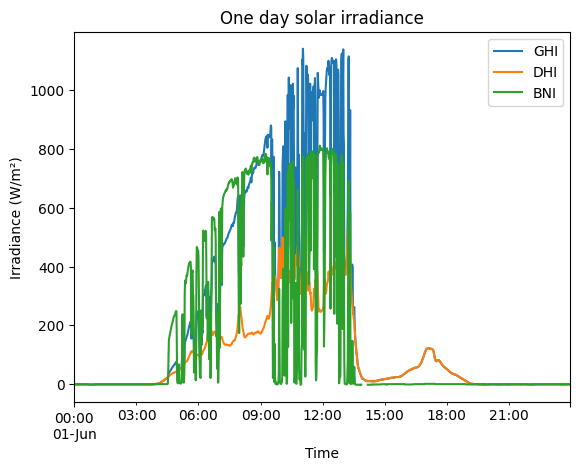

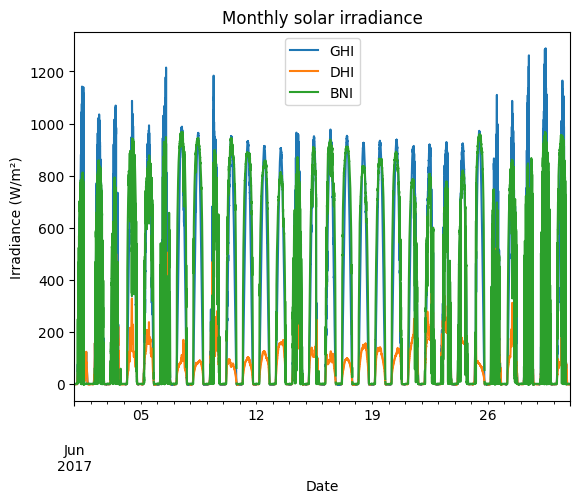

In [10]:
# For one day plot
insitu_data.loc['2017-06-01'].plot.line(y=["GHI", "DHI", "BNI"])
plt.title("One day solar irradiance")
plt.xlabel("Time")  # Adding X-axis title
plt.ylabel("Irradiance (W/m²)")  # Adding Y-axis title
plt.show()

# For monthly plot
insitu_data.loc['2017-06'].plot.line(y=["GHI", "DHI", "BNI"])
plt.title("Monthly solar irradiance")
plt.xlabel("Date")  # Adding X-axis title
plt.ylabel("Irradiance (W/m²)")  # Adding Y-axis title
plt.show()

### Visual Quality Control (QC)

The aim of the in situ solar irradiance quality check is to improve the reliability and accuracy of solar irradiance data by identifying and flagging potential issues or anomalies in the measurements. By performing these quality control checks, researchers and practitioners can ensure the quality of the data used for solar energy analysis, modeling, and forecasting, thereby enhancing the credibility and trustworthiness of their results.


Visual_qc is a `libinsitu` function that generates matplotlib graphs for visual quality control (QC). It takes a dataframe of input irradiance data, which should have a time index and three columns (GHI, DHI, BNI). The latitude, longitude, elevation, station ID, and station name can be passed as parameters or extracted from the metadata.

The function performs various computations and data clean-up steps, including resampling the data to minute resolution and computing the sun position and QC flags. It can also fetch horizons and compute mc_clear values if specified.

The resulting graphs display the measured irradiance data, sun position, QC flags, QC statistics, and other relevant information. These visualizations provide a comprehensive overview of the data quality and help identify any anomalies or issues in the measurements.

[12:55:52] INFO     -:-     QC: visual plot preparation

[12:55:52] INFO     -:-     plotting timeseries for GHI

[12:55:52] INFO     -:-     plotting timeseries for DNI

[12:55:52] INFO     -:-     plotting timeseries for DIF

[12:55:52] INFO     -:-     plotting heatmap timeseries for GHI

[12:55:53] INFO     -:-     plotting heatmap timeseries for DNI

[12:55:53] INFO     -:-     plotting heatmap timeseries for DIF

[12:55:56] INFO     -:-     Plotting QC test: BSRN 1C GHI: 0.00% / 0.00%

[12:55:57] INFO     -:-     Plotting QC test: BSRN 1C DNI: 0.00% / 0.00%

[12:55:58] INFO     -:-     Plotting QC test: BSRN 1C DIF: 0.00% / 0.00%

[12:55:58] INFO     -:-     Plotting QC test: BSRN-2C : 0.00%

[12:55:58] INFO     -:-     Plotting QC test: SERI-kn : 0.25%

[12:55:58] INFO     -:-     Plotting QC test: SERI-K : 0.72%

[12:55:59] INFO     -:-     Plotting QC test: BSRN closure : 0.02%

[12:55:59] INFO     -:-     Plotting QC test: BSRN closure: 0.02%

[12:56:00] INFO     -:-     QC: histograms of K, Kn & KT

[12:56:00] INFO     -:-     Shadow analysis (GHI)

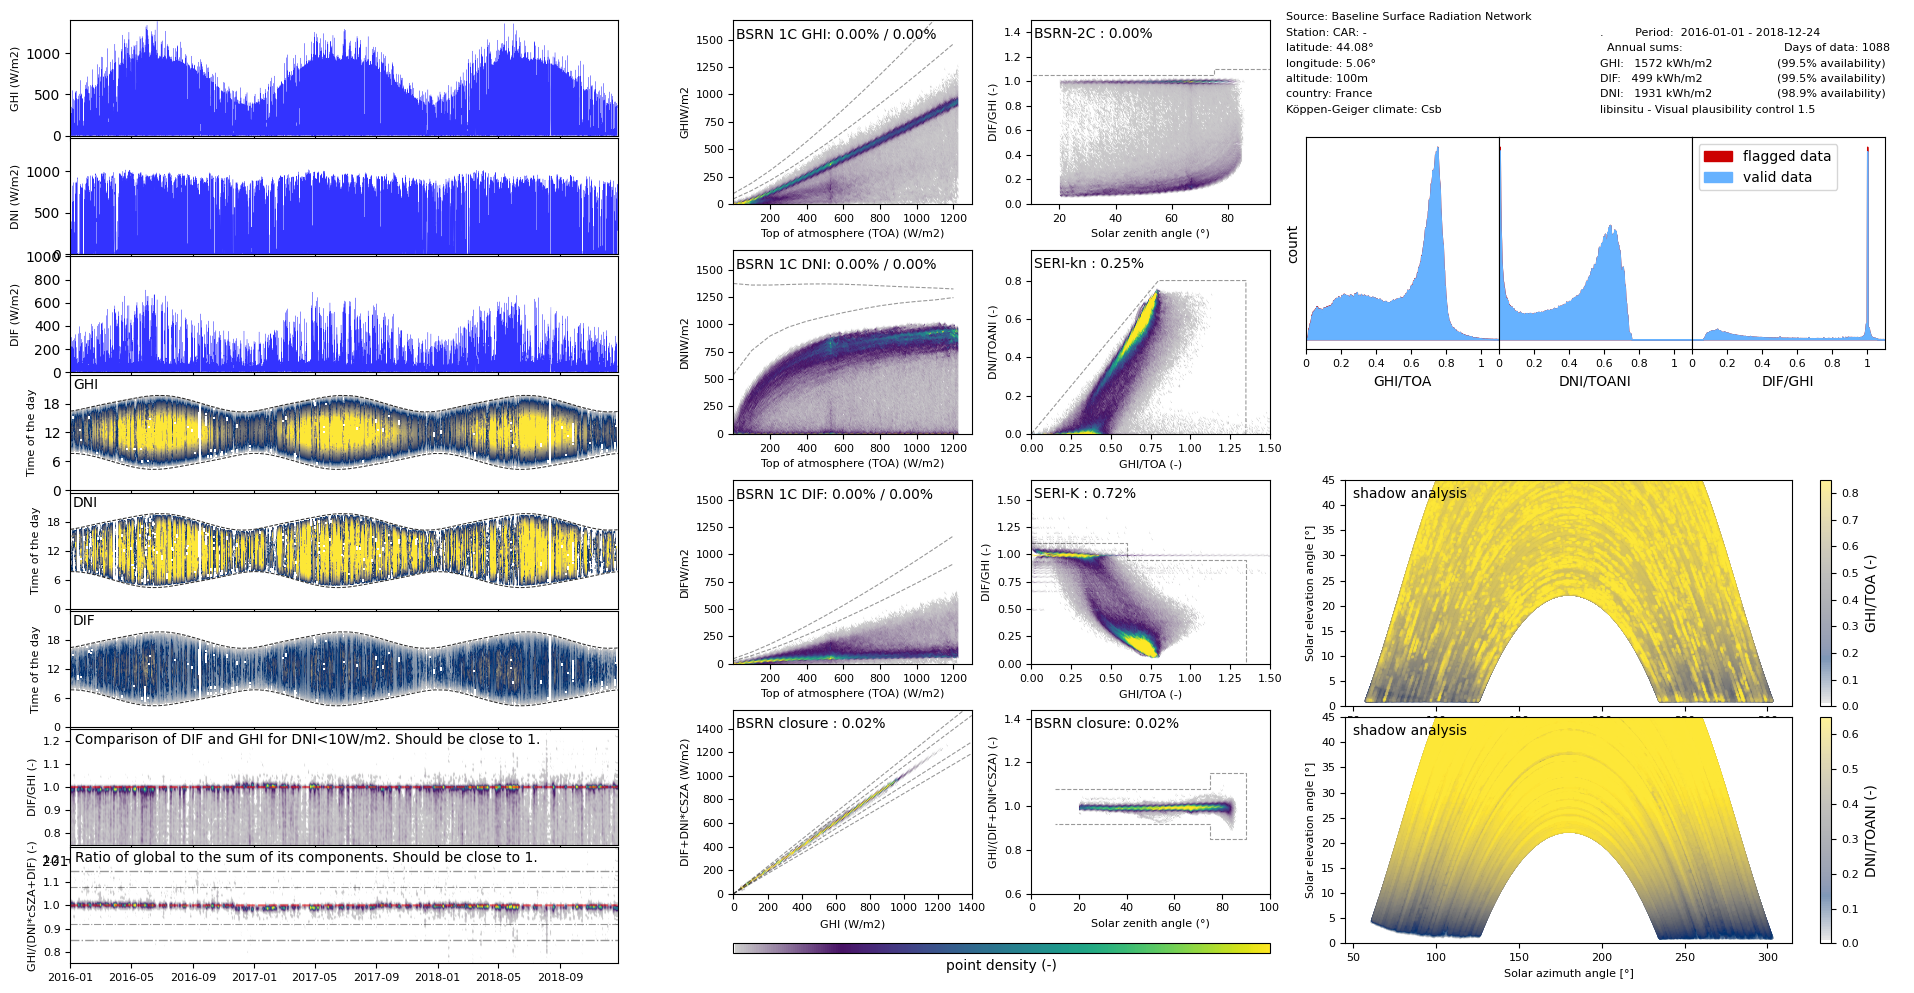

In [12]:
lis.visual_qc(insitu_data, latitude=float(latitude), longitude=float(longitude), elevation=float(elevation))

<div class="alert alert-block alert-warning"><b> Data seems valid with very few flagged data points.  </b>  </div>

## Copernicus Atmospheric Monitoring Service (CAMS) - Radiation

Retrieve satellite all-sky irradiance and clear-sky time series from `pvlib`-CAMS. Access requires registration here https://www.soda-pro.com

Reference: https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_cams.html

In [11]:
# Fetch all-sky and clear-sky data (McClear)

cams_data, cams_metadata = pvlib.iotools.get_cams(
    latitude, 
    longitude, 
    start, 
    end, 
    email='max.aragon_cerecedes@minesparis.psl.eu', # Add your SODA email account
    identifier='cams_radiation', # For all sky and clear sky data
    altitude=elevation, 
    time_step='1min', 
    time_ref='UT', 
    server='www.soda-is.com')  

cams_ghi = cams_data[['ghi']] # Satellite-derived all-sky values
mcclear_ghi = cams_data[['ghi_clear']] # Satellite-derived clear-sky values

In [13]:
cams_metadata

{'Coding': 'utf-8',
 'File format version': '2',
 'Title': 'CAMS Radiation Service v4.6 all-sky irradiation (derived from satellite data).',
 'Content': ' A time-series of solar radiation received on horizontal plane and plane always normal to the sun rays at ground level.',
 'Provider': 'MINES ParisTech (France)',
 'More information at': 'http://www.soda-pro.com/web-services/radiation/cams-radiation-service',
 'Date begin (ISO 8601)': '2016-01-01T00:00:00.0',
 'Date end (ISO 8601)': '2018-12-25T00:00:00.0',
 'Time reference': 'Universal time (UT)',
 'statisticalFunction': '"sum"',
 'Summarization (integration) period': '0 year 0 month 0 day 0 h 1 min 0 s',
 'noValue': 'nan',
 'File generated on': '2024-03-14',
 'latitude': 44.083,
 'longitude': 5.059,
 'altitude': 100.0,
 'radiation_unit': 'W/m^2',
 'time_step': '1min'}

<div class="alert alert-block alert-danger"><b> TODO: Create a combined (single) dataframe containing insitu_ghi, cams_ghi and mcclear_ghi, name it "cams_insitu_data". Ensure that their times correspond (e.g. UTC). </b>  </div>

<div class="alert alert-block alert-info"><b> HINT: To merge dataframes you can use Pandas functions such as merge, join, and concatenate. Also, we suggest to rename columns to improve readability. Remember! homogenise time zones. Have a loook to tz_localize and tz_convert. </b>  </div>

In [16]:
# code here

def prepare_and_merge_data(cams_data, insitu_data):
    # Extract 'ghi' columns and rename for clarity
    cams_ghi = cams_data[['ghi']].rename(columns={'ghi': 'cams_ghi'})
    insitu_ghi = insitu_data[['GHI']].rename(columns={'GHI': 'insitu_ghi'})
    mcclear_ghi = cams_data[['ghi_clear']].rename(columns={'ghi_clear': 'mcclear_ghi'})
    
    # Normalize timezone to UTC
    cams_ghi.index = cams_ghi.index.tz_localize('UTC') if cams_ghi.index.tz is None else cams_ghi.index.tz_convert('UTC')
    mcclear_ghi.index = mcclear_ghi.index.tz_localize('UTC') if mcclear_ghi.index.tz is None else mcclear_ghi.index.tz_convert('UTC')
    insitu_ghi.index = insitu_ghi.index.tz_localize('UTC') if insitu_ghi.index.tz is None else insitu_ghi.index.tz_convert('UTC')
    
    # Merge cams_ghi and insitu_ghi DataFrames on the index
    combined_data = pd.merge(cams_ghi, insitu_ghi, left_index=True, right_index=True, how='outer')
    
    # Merge mcclear_ghi with the combined DataFrame
    combined_data = pd.merge(combined_data, mcclear_ghi, left_index=True, right_index=True, how='outer')
    
    # Interpolate missing values in 'cams_ghi'
    combined_data['cams_ghi'] = combined_data['cams_ghi'].interpolate(method='linear')
    
    return combined_data

# Usage

cams_insitu_data = prepare_and_merge_data(cams_data, insitu_data)

cams_insitu_data

,cams_ghi,insitu_ghi,mcclear_ghi
2016-01-01 00:00:00+00:00,0.0,-1.0,0.0
2016-01-01 00:01:00+00:00,0.0,-1.0,0.0
2016-01-01 00:02:00+00:00,0.0,-1.0,0.0
2016-01-01 00:03:00+00:00,0.0,-1.0,0.0
2016-01-01 00:04:00+00:00,0.0,-1.0,0.0
...,...,...,...
2018-12-24 23:55:00+00:00,0.0,NaN,0.0
2018-12-24 23:56:00+00:00,0.0,NaN,0.0
2018-12-24 23:57:00+00:00,0.0,NaN,0.0
2018-12-24 23:58:00+00:00,0.0,NaN,0.0


<div class="alert alert-block alert-danger"><b> TODO: Plot "insitu_ghi" , "cams_ghi" and "mcclear_ghi" altogether for one day. Verify that their timezones correspond (e.g. UTC) </b>  </div>

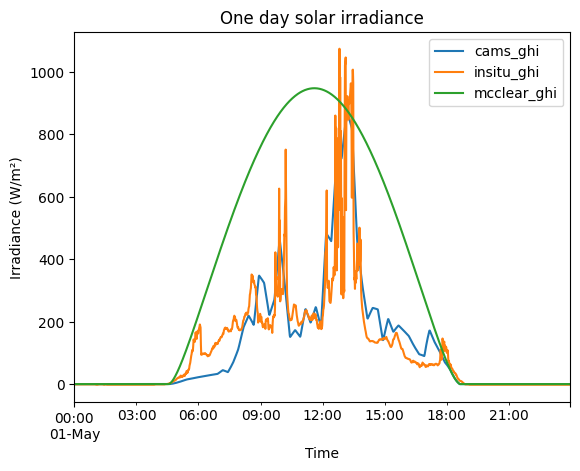

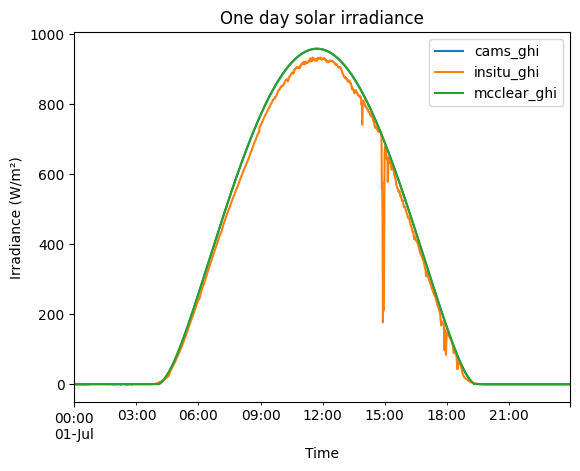

In [17]:
# code here

# For one day plot
cams_insitu_data.loc['2016-05-01'].plot.line(y=['cams_ghi', 'insitu_ghi', 'mcclear_ghi'])
plt.title("One day solar irradiance")
plt.xlabel("Time")  # Adding X-axis title
plt.ylabel("Irradiance (W/m²)")  # Adding Y-axis title
plt.show()

# For one day plot
cams_insitu_data.loc['2016-07-01'].plot.line(y=['cams_ghi', 'insitu_ghi', 'mcclear_ghi'])
plt.title("One day solar irradiance")
plt.xlabel("Time")  # Adding X-axis title
plt.ylabel("Irradiance (W/m²)")  # Adding Y-axis title
plt.show()

### Solar geometry <a id="cams-data"></a>

Solar geometry calculations, such as determining the position and movement of the sun in the sky, are crucial for solar energy applications. The Solar Geometry 2 (`SG2`) algorithm is used for accurate calculations of solar positions, zenith and azimuth angles. It takes into account factors like the Earth's elliptical orbit, axial tilt, and atmospheric refraction. By calculating solar declination, equation of time, solar hour angle, and applying atmospheric refraction corrections, the `SG2` algorithm provides reliable information about the sun's position. Python libraries like pvlib offer implementations of the `SG2` algorithm, making it easier to perform solar geometry calculations in solar energy analysis and forecasting workflows.

Source: Philippe Blanc, Lucien Wald. The SG2 algorithm for a fast and accurate computation of the po-
sition of the Sun for multi-decadal time period. Solar Energy, 2012, 88 (10) https://www.sciencedirect.com/science/article/abs/pii/S0038092X12002800

In [20]:
### Get solar angles

solar_angles = sg2.sun_position(np.array([[longitude, latitude, elevation]]), cams_insitu_data.index.values[:], ["topoc.gamma_S0", "topoc.alpha_S", "topoc.toa_hi"])
cams_insitu_data['solar_zenith'] = np.pi/2 - solar_angles.topoc.gamma_S0[0]
cams_insitu_data['solar_azimuth'] = solar_angles.topoc.alpha_S[0]

In [21]:
cams_insitu_data

,cams_ghi,insitu_ghi,mcclear_ghi,solar_zenith,solar_azimuth
2016-01-01 00:00:00+00:00,0.0,-1.0,0.0,2.769545,0.190499
2016-01-01 00:01:00+00:00,0.0,-1.0,0.0,2.768934,0.201401
2016-01-01 00:02:00+00:00,0.0,-1.0,0.0,2.768290,0.212272
2016-01-01 00:03:00+00:00,0.0,-1.0,0.0,2.767612,0.223109
2016-01-01 00:04:00+00:00,0.0,-1.0,0.0,2.766902,0.233911
...,...,...,...,...,...
2018-12-24 23:55:00+00:00,0.0,NaN,0.0,2.776385,0.173975
2018-12-24 23:56:00+00:00,0.0,NaN,0.0,2.775825,0.185065
2018-12-24 23:57:00+00:00,0.0,NaN,0.0,2.775231,0.196125
2018-12-24 23:58:00+00:00,0.0,NaN,0.0,2.774603,0.207152


<div class="alert alert-block alert-warning"><b> An important thing we can do with solar geometry information is filter by solar angles. </b>  </div>




<div class="alert alert-block alert-danger"><b> TODO: Filter the data using solar zenith angles to only keep day time values, determine whether the angle is in degrees or radians.  </b>  </div>

In [22]:
# code here

cams_insitu_data = cams_insitu_data[cams_insitu_data['solar_zenith'] <= np.deg2rad(90)]

cams_insitu_data

,cams_ghi,insitu_ghi,mcclear_ghi,solar_zenith,solar_azimuth
2016-01-01 07:21:00+00:00,0.132,4.0,1.038,1.568889,2.149125
2016-01-01 07:22:00+00:00,0.234,4.0,1.854,1.566267,2.152164
2016-01-01 07:23:00+00:00,0.354,4.0,2.802,1.563650,2.155208
2016-01-01 07:24:00+00:00,0.480,4.0,3.804,1.561039,2.158257
2016-01-01 07:25:00+00:00,0.612,4.0,4.848,1.558433,2.161310
...,...,...,...,...,...
2018-12-24 15:56:00+00:00,3.390,7.0,3.390,1.559812,4.113494
2018-12-24 15:57:00+00:00,2.370,6.0,2.370,1.562403,4.116546
2018-12-24 15:58:00+00:00,1.422,5.0,1.422,1.564999,4.119593
2018-12-24 15:59:00+00:00,0.630,5.0,0.630,1.567600,4.122636


### The clear sky index (kc) <a id="k-index"></a>


The clear sky index \( kc \), is a dimensionless parameter that provides a measure of the transparency of the atmosphere. It is defined as the ratio of the actual global solar irradiance (GSI) received at the Earth's surface (e.g. at an in-situ pyranometer) to the theoretical clear sky global solar irradiance (e.g. Mcclear model, Ineichen, Perez). It is used to assess the potential for solar energy generation and to study atmospheric conditions. $( K_c )$ is given by:

$ K_c = \frac{GSI}{GSI_{clear_{sky}}} $


Or more specifically here by:

$ K_c = \frac{insitu_{ghi}}{mcclear_{ghi}}$

$ K_c $ values range from 0 to 1, where a value close to 1 indicates clear conditions, and values decreasing towards 0 indicate increasing cloudiness or aerosol concentration.



<div class="alert alert-block alert-danger"><b> TODO: Resample the data to 10 minutes and then perform the operation to calculate 'kc' and add it to the dataframe as another column.  </b>  </div>

<div class="alert alert-block alert-info"><b> HINT: You can use the resample function and reduce the data using the mean, be aware of the kc calculation as dividing by zero may introduce undefined values. </b>  </div>


In [23]:
# code here

# Ensure cams_insitu_data is an independent DataFrame
cams_insitu_data_copy = cams_insitu_data.copy()

# Resample to 10 mins
cams_insitu_data_resample = cams_insitu_data_copy.resample("10min").mean().fillna(method='ffill')

# Calculate 'kc' only for mclear ghi were there is a value larger than zero else set nan values
cams_insitu_data_resample['kc'] = np.where(cams_insitu_data_resample['mcclear_ghi'] > 0, cams_insitu_data_resample['insitu_ghi'] / cams_insitu_data_resample['mcclear_ghi'], np.nan) 

cams_insitu_data_resample

,cams_ghi,insitu_ghi,mcclear_ghi,solar_zenith,solar_azimuth,kc
2016-01-01 07:20:00+00:00,0.630667,4.444445,5.003333,1.558451,2.161326,0.888297
2016-01-01 07:30:00+00:00,2.169600,6.700000,17.233200,1.533969,2.190573,0.388784
2016-01-01 07:40:00+00:00,4.323600,12.300000,34.347600,1.508745,2.221837,0.358104
2016-01-01 07:50:00+00:00,6.820800,18.600000,54.181200,1.484120,2.253626,0.343293
2016-01-01 08:00:00+00:00,9.521400,20.100000,75.633000,1.460128,2.285967,0.265757
...,...,...,...,...,...,...
2018-12-24 15:20:00+00:00,58.046400,29.000000,58.046400,1.481175,4.014797,0.499600
2018-12-24 15:30:00+00:00,37.332600,16.799999,37.332600,1.505503,4.046680,0.450009
2018-12-24 15:40:00+00:00,19.077000,12.100000,19.077000,1.530442,4.078035,0.634272
2018-12-24 15:50:00+00:00,5.184600,8.300000,5.184600,1.555959,4.108888,1.600895


### Storing data and meta-data <a id="netcdf"></a>

<div class="alert alert-block alert-danger"><b> TODO: Save the dataframe as a NetCDF file and include metadata, i.e. latitude, longitude, elevation and time zone. </b>  </div>

<div class="alert alert-block alert-info"><b> HINT: check the documentation of xarray https://docs.xarray.dev/en/latest/generated/xarray.Dataset.to_netcdf.html   </b>  </div>
 

In [24]:
# code here

xr_dataset = xr.Dataset.from_dataframe(cams_insitu_data_resample.reset_index())

# Convert the DataFrame's DatetimeIndex to a datetime64 data type
xr_dataset['time'] = pd.to_datetime(xr_dataset['index']).values

# Drop index
xr_dataset = xr_dataset.drop_vars('index')


for var in xr_dataset.data_vars:
    # Create a new data variable that is indexed by 'time' instead of 'index'
    # This assumes that the time dimension has the same length and ordering as the 'index' dimension
    xr_dataset[var] = (('time',), xr_dataset[var].values)


# Add variable attribute metadata as global attributes
xr_dataset.attrs['latitude'] = float(latitude)
xr_dataset.attrs['longitude'] = float(longitude)
xr_dataset.attrs['elevation'] = float(elevation)
xr_dataset.attrs['time standard'] = 'UTC'

# Add additional global attribute metadata
xr_dataset.attrs['Conventions'] = 'CF-1.6'
xr_dataset.attrs['Station'] = 'Carpentras'
xr_dataset.attrs['Network'] = 'Baseline Surface Radiation Network (BSRN)'
xr_dataset.attrs['Summary'] = 'Daytime data'


xr_dataset.to_netcdf('solar_forecasting_ready.nc')

In [25]:
xr_dataset

<xarray.Dataset>
Dimensions:        (time: 156725)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01T07:20:00 ... 2018-12-24T1...
Data variables:
    cams_ghi       (time) float64 0.6307 2.17 4.324 6.821 ... 19.08 5.185 0.0
    insitu_ghi     (time) float32 4.444 6.7 12.3 18.6 20.1 ... 16.8 12.1 8.3 4.0
    mcclear_ghi    (time) float64 5.003 17.23 34.35 54.18 ... 19.08 5.185 0.0
    solar_zenith   (time) float64 1.558 1.534 1.509 1.484 ... 1.53 1.556 1.57
    solar_azimuth  (time) float64 2.161 2.191 2.222 2.254 ... 4.078 4.109 4.126
    kc             (time) float64 0.8883 0.3888 0.3581 ... 0.6343 1.601 nan
Attributes:
    latitude:       44.08300018310547
    longitude:      5.059000015258789
    elevation:      100.0
    time standard:  UTC
    Conventions:    CF-1.6
    Station:        Carpentras
    Network:        Baseline Surface Radiation Network (BSRN)
    Summary:        Daytime data

# <a id="modeling-ssi-data"></a>Forecasting Solar Surface Irradiance

In this section, we will dive into forecasting Solar Surface Irradiance (SSI) data. Our goal is to predict in-situ SSI values. To begin, we will explore a couple of traditional approaches. Feel free to experiment with these methods or propose your own innovative approaches as we progress.

In [ ]:
# Open the netCDF file using xarray
data = xr.open_dataset('solar_forecasting_ready.nc')

# Convert the xarray Dataset to a pandas DataFrame
data = data.to_dataframe()


data

## Persistance and smart persistance

Persistence forecasting assumes future conditions will remain the same as the current conditions. It is a simple yet effective baseline for short-term solar irradiance predictions. **Smart Persistence Forecasting** enhances the simple persistence forecast by incorporating recent atmospheric conditions. One standard approach to refine the forecast is by considering the previous clear sky index with the current clear sky GHI to predict the next GHI value, assuming that the recent relationship between actual and clear sky irradiance continues into the immediate future. The equation for smart persistence forecasting is:

$$ GHI_{}^{smart} = k_{c,t-1} \times GHI_{clr,t} $$


In our case, the equation is as follows:

$$ Smart Persistance = k_{c,t-1} \times mcclear_{t} $$


<div class="alert alert-block alert-danger"><b> TODO: Implement persistance and smart persistance for the entire dataset and calcuate the root mean square error with the actual insitu_ghi value to compare their performance.</b>  </div>

In [6]:
data['kc_prev'] = data['kc'].shift(1)

data

,cams_ghi,insitu_ghi,mcclear_ghi,solar_zenith,solar_azimuth,kc,kc_prev
time,,,,,,,
2016-01-01 07:20:00,0.630667,4.444445,5.003333,1.558451,2.161326,0.888297,NaN
2016-01-01 07:30:00,2.169600,6.700000,17.233200,1.533969,2.190573,0.388784,0.888297
2016-01-01 07:40:00,4.323600,12.300000,34.347600,1.508745,2.221837,0.358104,0.388784
2016-01-01 07:50:00,6.820800,18.600000,54.181200,1.484120,2.253626,0.343293,0.358104
2016-01-01 08:00:00,9.521400,20.100000,75.633000,1.460128,2.285967,0.265757,0.343293
...,...,...,...,...,...,...,...
2018-12-23 15:10:00,72.736200,78.099998,72.736200,1.458898,3.983801,1.073743,1.000868
2018-12-23 15:20:00,51.736200,54.500000,51.736200,1.482608,4.016208,1.053421,1.073743
2018-12-23 15:30:00,32.498400,34.299999,32.498400,1.506964,4.048060,1.055437,1.053421


In [8]:
# code here

# Apply Persistence Forecast
data['persistence'] = data['insitu_ghi'].shift(1)

# Recalculate Smart Persistence Forecast with adjusted clear sky index
data['smart_persistence'] = data['kc'].shift(1) * data['mcclear_ghi']

# Drop rows where forecast cannot be computed (e.g., first row and rows with NaN in adjusted_clear_sky_index)
data.dropna(subset=['persistence', 'smart_persistence'], inplace=True)

# Recalculate RMSE for both methods with adjusted data
rmse_persistence = np.sqrt(mean_squared_error(data['insitu_ghi'], data['persistence']))
rmse_smart_persistence = np.sqrt(mean_squared_error(data['insitu_ghi'], data['smart_persistence']))

data

,cams_ghi,insitu_ghi,mcclear_ghi,solar_zenith,solar_azimuth,kc,persistence,smart_persistence
time,,,,,,,,
2016-01-01 07:30:00,2.1696,6.700000,17.2332,1.533969,2.190573,0.388784,4.444445,15.308195
2016-01-01 07:40:00,4.3236,12.300000,34.3476,1.508745,2.221837,0.358104,6.700000,13.353812
2016-01-01 07:50:00,6.8208,18.600000,54.1812,1.484120,2.253626,0.343293,12.300000,19.402484
2016-01-01 08:00:00,9.5214,20.100000,75.6330,1.460128,2.285967,0.265757,18.600000,25.964243
2016-01-01 08:10:00,11.9064,22.900000,97.9596,1.436807,2.318885,0.233770,20.100000,26.033451
...,...,...,...,...,...,...,...,...
2018-12-23 15:10:00,72.7362,78.099998,72.7362,1.458898,3.983801,1.073743,94.800003,72.799326
2018-12-23 15:20:00,51.7362,54.500000,51.7362,1.482608,4.016208,1.053421,78.099998,55.551392
2018-12-23 15:30:00,32.4984,34.299999,32.4984,1.506964,4.048060,1.055437,54.500000,34.234497


In [9]:
print(f' RMSE persistance: {rmse_persistence}, RMSE smart persistance: {rmse_smart_persistence}')

 RMSE persistance: 45.1340217590332, RMSE smart persistance: 43.90464145402611


<div class="alert alert-block alert-danger"><b> TODO: Visualise insitu_ghi as well as persistance and smart peristance.</b>  </div>

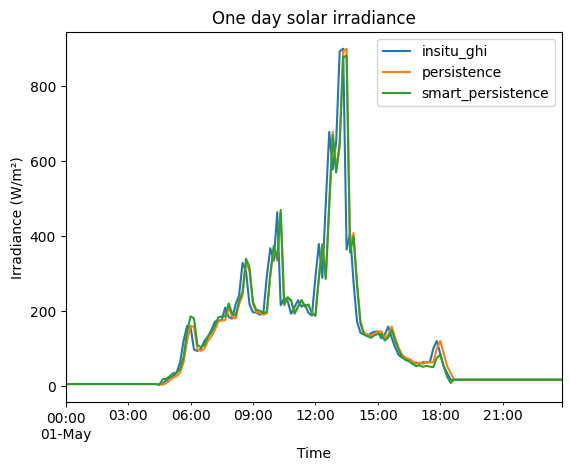

In [34]:
# For one day plot

data.loc['2016-05-01'].plot.line(y=['insitu_ghi', 'persistence', 'smart_persistence'])
plt.title("One day solar irradiance")
plt.xlabel("Time")  # Adding X-axis title
plt.ylabel("Irradiance (W/m²)")  # Adding Y-axis title
plt.show()

# Live Solar Forecasting Hands-on


We will embark on live solar forecasting to get a sense of the intra-day power market dynamics. Every 10 minutes solar data values will be updated. The goal of this task is to utilise your acquired knowledge in solar forecasting to predict the future 2 hours ahead. Specifically, you will use observations from the past to predict the next 12 steps (remember, our data is resampled to every 10 minutes). We will focus on Global Horizontal Irradiance from in-situ measurements. 

## Steps for sending live solar forecasts. 

1. Precompute McClear Clear-Sky Irradiation (only once).
2. Request and process the data (every 10 minutes will be updated).
3. Compute your forecast. 
4. Push results to the server (every 10 minutes).

### Precompute McClear Clear-Sky Irradiation service 

In [12]:
#clear sky data from CAMS

cams_data = pvlib.iotools.get_cams(
        latitude='44.08300018310547', 
        longitude='5.059000015258789', 
        start=datetime(2016, 1, 1), 
        end=datetime(2018, 12, 25),
        email='vadim.becquet@gmail.com',  # Add you email account
        identifier='mcclear', 
        altitude='100.0', 
        time_step='1min', 
        time_ref='UT', 
        verbose=False, 
        integrated=False, 
        label=None, 
        map_variables=True, 
        server='www.soda-is.com', 
        timeout=180)[0]
    
cams_data.index = cams_data.index.tz_convert(None)  # Convert time index

In [13]:
# Retrieve data from 2016, 2017, and 2018

def request_solar_data(cams_data):

    TDS_URL="http://tds.webservice-energy.org/thredds/dodsC/sws/live.nc"
    TDS_USER="sws"
    TDS_PASS="2023!SolWs"
    df_insitu = lis.netcdf_to_dataframe(TDS_URL, user=TDS_USER, password=TDS_PASS)

    # Extract location attributes
    lat = df_insitu.attrs['latitude']
    lon = df_insitu.attrs['longitude']
    alt = df_insitu.attrs['elevation']
    
    # Compute QC flags and merge with original data
    qc_flags = lis.compute_qc_flags(df_insitu, lat=lat, lon=lon, alt=alt)
    data = df_insitu.merge(qc_flags[['QCfinal']], left_index=True, right_index=True, how='left')
    
    # Compute solar angles
    solar_angles = sg2.sun_position(np.array([[lon, lat, alt]]), data.index.values, ["topoc.gamma_S0", "topoc.alpha_S", "topoc.toa_hi"])
    data['solar_zenith'] = np.pi/2 - solar_angles.topoc.gamma_S0[0]
    data['solar_azimuth'] = solar_angles.topoc.alpha_S[0]
    data['TOA_HI'] = solar_angles.topoc.toa_hi[0]
    data['BHI'] = data['BNI'] * np.cos(data['solar_zenith'])
    
    data = data.join(cams_data[['ghi_clear', 'dhi_clear', 'bhi_clear', 'dni_clear']], how='inner')
    
    # Resample, compute Kc, and filter data
    data = data.resample("10min").mean()
    data['kc'] = np.where(data['ghi_clear'] > 0, data['GHI'] / data['ghi_clear'], np.nan) 
    data = data[data["QCfinal"] == False]
    
    df = data.copy()
    df.drop(['QC', 'QCfinal', 'DHI', 'BNI', 'BHI'], axis=1, inplace=True)
    df = df.resample("10min").mean()
    df = df[(df['solar_zenith'] <= np.deg2rad(90)) & (df['GHI'] >= 0)]
    
    return df, lat, lon, alt

data, lat, lon, alt = request_solar_data(cams_data)

In [5]:
data

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2016-01-01 07:30:00,6.700000,278.887512,0.961426,101200.0,1.533969,2.190573,51.862741,17.2332,13.5756,3.6576,90.7152,0.388784
2016-01-01 07:40:00,12.300000,278.937500,0.961914,101200.0,1.508745,2.221837,87.348382,34.3476,22.5024,11.8458,184.4166,0.358104
2016-01-01 07:50:00,18.600000,278.893738,0.961914,101200.0,1.484120,2.253626,121.938684,54.1812,30.5958,23.5848,266.9820,0.343293
2016-01-01 08:00:00,20.100000,278.875000,0.962500,101200.0,1.460128,2.285967,155.567850,75.6330,37.7580,37.8750,338.2134,0.265757
2016-01-01 08:10:00,22.900000,278.843750,0.962598,101200.0,1.436807,2.318885,188.171908,97.9596,44.0364,53.9256,399.4956,0.233770
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 15:00:00,46.799999,289.343750,0.558105,101000.0,1.434499,3.949335,191.313028,102.6588,38.5128,64.1466,475.2972,0.455879
2018-12-24 15:10:00,32.500000,289.125000,0.564746,101000.0,1.457495,3.982356,159.186752,80.0640,33.4434,46.6212,415.5216,0.405925
2018-12-24 15:20:00,29.000000,289.081238,0.569141,101000.0,1.481175,4.014797,126.017248,58.0464,27.6120,30.4350,342.8652,0.499600
2018-12-24 15:30:00,16.799999,289.081238,0.566699,101000.0,1.505503,4.046680,91.867620,37.3326,20.8980,16.4346,253.5792,0.450009


<div class="alert alert-block alert-success" style="font-size: 22px; font-weight: bold; text-align: center; margin-bottom: 0;">
    Smart persistence example
</div>


### Data request

In [27]:
# Get updated data

data, lat, lon, alt = request_solar_data(cams_data); data

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2016-01-01 07:30:00,6.700000,278.887512,0.961426,101200.0,1.533969,2.190573,51.862741,17.2332,13.5756,3.6576,90.7152,0.388784
2016-01-01 07:40:00,12.300000,278.937500,0.961914,101200.0,1.508745,2.221837,87.348382,34.3476,22.5024,11.8458,184.4166,0.358104
2016-01-01 07:50:00,18.600000,278.893738,0.961914,101200.0,1.484120,2.253626,121.938684,54.1812,30.5958,23.5848,266.9820,0.343293
2016-01-01 08:00:00,20.100000,278.875000,0.962500,101200.0,1.460128,2.285967,155.567850,75.6330,37.7580,37.8750,338.2134,0.265757
2016-01-01 08:10:00,22.900000,278.843750,0.962598,101200.0,1.436807,2.318885,188.171908,97.9596,44.0364,53.9256,399.4956,0.233770
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 15:00:00,46.799999,289.343750,0.558105,101000.0,1.434499,3.949335,191.313028,102.6588,38.5128,64.1466,475.2972,0.455879
2018-12-24 15:10:00,32.500000,289.125000,0.564746,101000.0,1.457495,3.982356,159.186752,80.0640,33.4434,46.6212,415.5216,0.405925
2018-12-24 15:20:00,29.000000,289.081238,0.569141,101000.0,1.481175,4.014797,126.017248,58.0464,27.6120,30.4350,342.8652,0.499600
2018-12-24 15:30:00,16.799999,289.081238,0.566699,101000.0,1.505503,4.046680,91.867620,37.3326,20.8980,16.4346,253.5792,0.450009


<div class="alert alert-block alert-danger"><b> TODO: Print the latest values.</b>  </div>

In [7]:
# code here

data.tail()

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2018-12-24 15:00:00,46.799999,289.343750,0.558105,101000.0,1.434499,3.949335,191.313028,102.6588,38.5128,64.1466,475.2972,0.455879
2018-12-24 15:10:00,32.500000,289.125000,0.564746,101000.0,1.457495,3.982356,159.186752,80.0640,33.4434,46.6212,415.5216,0.405925
2018-12-24 15:20:00,29.000000,289.081238,0.569141,101000.0,1.481175,4.014797,126.017248,58.0464,27.6120,30.4350,342.8652,0.499600
2018-12-24 15:30:00,16.799999,289.081238,0.566699,101000.0,1.505503,4.046680,91.867620,37.3326,20.8980,16.4346,253.5792,0.450009
2018-12-24 15:40:00,12.100000,288.931244,0.581055,101040.0,1.530442,4.078035,56.802833,19.0770,13.2144,5.8626,143.5464,0.634272


### Solar forecast

The output dataframe must contain 2 columns, time index and GHI values. It must also contain 13 rows, the first row represents the latest "real" observation and the following 12 rows represent 2 hours of solar forecasting.

In [8]:
def smart_persistence(df, lat, lon, alt):
    """
    Generates a smart persistence forecast DataFrame for GHI using the last observed kc value
    and clear sky estimates from the Ineichen model.
    
    Parameters:
    - df: DataFrame with the historical solar data including 'kc' values.
    - lat: Latitude of the location.
    - lon: Longitude of the location.
    - alt: Altitude of the location in meters.
    
    Returns:
    - DataFrame with the forecasted GHI values.
    """
    # Generate future timestamps
    smart_persistence_df = pd.DataFrame.from_records(
        [dict(index=df.index[-1] + timedelta(minutes=10)*i, GHI=0) for i in range(13)], 
        index='index'
    )
    
    # Get clear sky GHI data
    location = pvlib.location.Location(lat, lon, altitude=alt)
    time = smart_persistence_df.index
    clear_sky_data = location.get_clearsky(time, model='ineichen')
    smart_persistence_df['ghi_ineichen'] = clear_sky_data['ghi']
    
    # Apply the last observed kc value to forecast GHI
    last_kc = df['kc'].iloc[-1]
    smart_persistence_df['GHI'] = smart_persistence_df['ghi_ineichen'] * last_kc
    
    # Keep only the forecasted GHI column
    smart_persistence_df = smart_persistence_df[['GHI']]
    
    return smart_persistence_df

# Usage example:

smart_persistence_df = smart_persistence(data, lat, lon, alt)

smart_persistence_df

,GHI
index,
2018-12-24 15:40:00,9.074175
2018-12-24 15:50:00,2.760375
2018-12-24 16:00:00,0.235566
2018-12-24 16:10:00,0.000000
2018-12-24 16:20:00,0.000000
2018-12-24 16:30:00,0.000000
2018-12-24 16:40:00,0.000000
2018-12-24 16:50:00,0.000000
2018-12-24 17:00:00,0.000000


### Send forecast to the server

In [79]:
publish.publish_forecast("smart_persistence",  smart_persistence_df)

<div class="alert alert-block alert-success" style="font-size: 22px; font-weight: bold; text-align: center; margin-bottom: 0;">
    Linear regression example
</div>


In [14]:
# Get updated data

data, lat, lon, alt = request_solar_data(cams_data); data

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2016-01-01 07:30:00,6.700000,278.887512,0.961426,101200.0,1.533969,2.190573,51.862741,17.2332,13.5756,3.6576,90.7152,0.388784
2016-01-01 07:40:00,12.300000,278.937500,0.961914,101200.0,1.508745,2.221837,87.348382,34.3476,22.5024,11.8458,184.4166,0.358104
2016-01-01 07:50:00,18.600000,278.893738,0.961914,101200.0,1.484120,2.253626,121.938684,54.1812,30.5958,23.5848,266.9820,0.343293
2016-01-01 08:00:00,20.100000,278.875000,0.962500,101200.0,1.460128,2.285967,155.567850,75.6330,37.7580,37.8750,338.2134,0.265757
2016-01-01 08:10:00,22.900000,278.843750,0.962598,101200.0,1.436807,2.318885,188.171908,97.9596,44.0364,53.9256,399.4956,0.233770
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 13:20:00,165.100006,289.787506,0.571484,100920.0,1.250823,3.584104,442.877103,300.0756,66.5304,233.5446,743.9706,0.550195
2018-12-24 13:30:00,208.699997,289.837494,0.572656,100940.0,1.264793,3.623531,424.162936,284.6676,64.8024,219.8634,731.4780,0.733136
2018-12-24 13:40:00,173.899994,289.750000,0.573242,101000.0,1.279848,3.662335,403.901441,268.0704,62.9118,205.1586,716.9958,0.648710
2018-12-24 13:50:00,129.100006,289.643738,0.574121,101000.0,1.295950,3.700499,382.131163,250.3464,60.8406,189.5070,700.2480,0.515685


In [10]:
# Model

def linear_regression_forecast(data, lat, lon, alt):
    # Ensure no NaNs in the data
    df = data.dropna().copy()

    # Create lag features for the time series data
    for i in range(1, 3):
        df[f'lag_{i}'] = df['GHI'].shift(i)

    # Drop rows with NaN values resulting from shifting
    df.dropna(inplace=True)

    # Keep all 'lag_' columns, 'GHI', and 'ghi_clear'
    df = df.filter(regex='lag_|GHI|ghi_clear')

    # Split the data into training and testing datasets
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Prepare the training and testing data
    X_train = train.drop(['GHI'], axis=1)
    y_train = train['GHI']
    X_test = test.drop(['GHI'], axis=1)
    y_test = test['GHI']
    
    # Create and fit the Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Use the fitted model to make predictions on the test data
    y_pred = lr_model.predict(X_test)

    # Calculate the RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Print the RMSE
    print(f"RMSE: {rmse:.2f}")

    # Define the number of future time steps you want to predict
    future_steps = 12

    # Generate future timestamps starting from the last timestamp in the input DataFrame
    forecast_index = pd.date_range(start=df.index[-1] + timedelta(minutes=10), periods=future_steps, freq='10T')

    # Get clear sky GHI data for the future timestamps
    location = pvlib.location.Location(lat, lon, altitude=alt)
    clear_sky_data = location.get_clearsky(forecast_index, model='ineichen')

    # Initialize the DataFrame for the recursive forecast
    last_step = test.iloc[[-1]][['ghi_clear', 'lag_1', 'lag_2']]

    # Initialize an empty list to store the predictions
    predictions = []

    # Perform recursive forecasting
    for i in range(future_steps):
        # Update the 'ghi_clear' with clear sky GHI data
        last_step['ghi_clear'] = clear_sky_data['ghi'].iloc[i]

        # Predict the next step
        next_step_pred = lr_model.predict(last_step)

        # Append the prediction
        predictions.append(next_step_pred.item())

        # Update the lags
        last_step['lag_2'] = last_step['lag_1']
        last_step['lag_1'] = next_step_pred.item()
        
    #print(test)

    # Construct the forecast DataFrame
    forecast_index = pd.date_range(start=test.index[-2], periods=future_steps + 2, freq='10T', inclusive='right')
    forecast_values = pd.DataFrame([test.iloc[-1]['GHI']]+predictions, index=forecast_index, columns=['GHI'])
    
    return forecast_values

In [11]:
linear_regression_df = linear_regression_forecast(data, lat, lon, alt)
linear_regression_df

RMSE: 58.17


,GHI
2018-12-24 15:40:00,12.100000
2018-12-24 15:50:00,11.943938
2018-12-24 16:00:00,7.198787
2018-12-24 16:10:00,2.901898
2018-12-24 16:20:00,-0.960529
2018-12-24 16:30:00,-4.432543
2018-12-24 16:40:00,-7.553606
2018-12-24 16:50:00,-10.359193
2018-12-24 17:00:00,-12.881192
2018-12-24 17:10:00,-15.148268


In [63]:
# Publish forecast

publish.publish_forecast("linear_regression", linear_regression_df)

<div class="alert alert-block alert-success" style="font-size: 22px; font-weight: bold; text-align: center; margin-bottom: 0;">
   Random forest example
</div>


In [12]:
# Get updated data:

data, lat, lon, alt = request_solar_data(cams_data); data

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2016-01-01 07:30:00,6.700000,278.887512,0.961426,101200.0,1.533969,2.190573,51.862741,17.2332,13.5756,3.6576,90.7152,0.388784
2016-01-01 07:40:00,12.300000,278.937500,0.961914,101200.0,1.508745,2.221837,87.348382,34.3476,22.5024,11.8458,184.4166,0.358104
2016-01-01 07:50:00,18.600000,278.893738,0.961914,101200.0,1.484120,2.253626,121.938684,54.1812,30.5958,23.5848,266.9820,0.343293
2016-01-01 08:00:00,20.100000,278.875000,0.962500,101200.0,1.460128,2.285967,155.567850,75.6330,37.7580,37.8750,338.2134,0.265757
2016-01-01 08:10:00,22.900000,278.843750,0.962598,101200.0,1.436807,2.318885,188.171908,97.9596,44.0364,53.9256,399.4956,0.233770
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 15:00:00,46.799999,289.343750,0.558105,101000.0,1.434499,3.949335,191.313028,102.6588,38.5128,64.1466,475.2972,0.455879
2018-12-24 15:10:00,32.500000,289.125000,0.564746,101000.0,1.457495,3.982356,159.186752,80.0640,33.4434,46.6212,415.5216,0.405925
2018-12-24 15:20:00,29.000000,289.081238,0.569141,101000.0,1.481175,4.014797,126.017248,58.0464,27.6120,30.4350,342.8652,0.499600
2018-12-24 15:30:00,16.799999,289.081238,0.566699,101000.0,1.505503,4.046680,91.867620,37.3326,20.8980,16.4346,253.5792,0.450009


In [14]:
# Model

def random_forest(data, lat, lon, alt):
    # Ensure no NaNs in the data
    df = data.dropna().copy()

    # Create lag features for the time series data
    for i in range(1, 3):
        df[f'lag_{i}'] = df['GHI'].shift(i)
    
    df.dropna(inplace=True)
    df = df.filter(regex='lag|GHI|ghi_clear')

    # Split the data into training and testing datasets
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Prepare the training and testing data
    X_train = train.drop(['GHI'], axis=1)
    y_train = train['GHI']
    X_test = test.drop(['GHI'], axis=1)
    y_test = test['GHI']

    # Create and fit the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
    rf_model.fit(X_train, y_train)

    # Use the fitted model to make predictions on the test data
    y_pred = rf_model.predict(X_test)

    # Calculate the RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the RMSE
    print(f"RMSE: {rmse:.2f}")
    
    # Define the number of future time steps you want to predict
    future_steps = 12

    # Generate future timestamps starting from the last timestamp in the input DataFrame
    forecast_index = pd.date_range(start=df.index[-1] + timedelta(minutes=10), periods=future_steps, freq='10T')

    # Get clear sky GHI data for the future timestamps
    location = pvlib.location.Location(lat, lon, altitude=alt)
    clear_sky_data = location.get_clearsky(forecast_index, model='ineichen')

    # Initialize the DataFrame for the recursive forecast
    last_step = test.iloc[[-1]][['ghi_clear', 'lag_1', 'lag_2']]

    # Initialize an empty list to store the predictions
    predictions = []

    # Perform recursive forecasting
    for i in range(future_steps):
        # Update the 'ghi_clear' with clear sky GHI data
        last_step['ghi_clear'] = clear_sky_data['ghi'].iloc[i]

        # Predict the next step
        next_step_pred = rf_model.predict(last_step)

        # Append the prediction
        predictions.append(next_step_pred.item())

        # Update the lags
        last_step['lag_2'] = last_step['lag_1']
        last_step['lag_1'] = next_step_pred.item()

     # Construct the forecast DataFrame
    forecast_index = pd.date_range(start=test.index[-2], periods=future_steps + 2, freq='10T', inclusive='right')
    forecast_values = pd.DataFrame([test.iloc[-1]['GHI']]+predictions, index=forecast_index, columns=['GHI'])
    
    return forecast_values

In [15]:
random_forest_df = random_forest(data, lat, lon, alt)
random_forest_df

RMSE: 58.09


,GHI
2018-12-24 15:40:00,12.100000
2018-12-24 15:50:00,4.270000
2018-12-24 16:00:00,1.196667
2018-12-24 16:10:00,0.210000
2018-12-24 16:20:00,0.830000
2018-12-24 16:30:00,1.110000
2018-12-24 16:40:00,0.550000
2018-12-24 16:50:00,0.510000
2018-12-24 17:00:00,0.510000
2018-12-24 17:10:00,0.510000


In [16]:
publish.publish_forecast("random_forest", random_forest_df)

<div class="alert alert-block alert-success" style="font-size: 22px; font-weight: bold; text-align: center; margin-bottom: 0;">
    Xgboost example
</div>


In [22]:
# Get updated data:

data, lat, lon, alt = request_solar_data(cams_data); data

,GHI,T2,RH,P,solar_zenith,solar_azimuth,TOA_HI,ghi_clear,dhi_clear,bhi_clear,dni_clear,kc
2016-01-01 07:30:00,6.700000,278.887512,0.961426,101200.0,1.533969,2.190573,51.862741,17.2332,13.5756,3.6576,90.7152,0.388784
2016-01-01 07:40:00,12.300000,278.937500,0.961914,101200.0,1.508745,2.221837,87.348382,34.3476,22.5024,11.8458,184.4166,0.358104
2016-01-01 07:50:00,18.600000,278.893738,0.961914,101200.0,1.484120,2.253626,121.938684,54.1812,30.5958,23.5848,266.9820,0.343293
2016-01-01 08:00:00,20.100000,278.875000,0.962500,101200.0,1.460128,2.285967,155.567850,75.6330,37.7580,37.8750,338.2134,0.265757
2016-01-01 08:10:00,22.900000,278.843750,0.962598,101200.0,1.436807,2.318885,188.171908,97.9596,44.0364,53.9256,399.4956,0.233770
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 15:00:00,46.799999,289.343750,0.558105,101000.0,1.434499,3.949335,191.313028,102.6588,38.5128,64.1466,475.2972,0.455879
2018-12-24 15:10:00,32.500000,289.125000,0.564746,101000.0,1.457495,3.982356,159.186752,80.0640,33.4434,46.6212,415.5216,0.405925
2018-12-24 15:20:00,29.000000,289.081238,0.569141,101000.0,1.481175,4.014797,126.017248,58.0464,27.6120,30.4350,342.8652,0.499600
2018-12-24 15:30:00,16.799999,289.081238,0.566699,101000.0,1.505503,4.046680,91.867620,37.3326,20.8980,16.4346,253.5792,0.450009


In [23]:
def xgboost_forecast(data, lat, lon, alt):
    # Ensure no NaNs in the data
    df = data.dropna().copy()

    # Create lag features for the time series data
    for i in range(1, 3):
        df[f'lag_{i}'] = df['GHI'].shift(i)
    
    df.dropna(inplace=True)
    df = df.filter(regex='lag|GHI|ghi_clear')

    # Split the data into training and testing datasets
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Prepare the training and testing data
    X_train = train.drop(['GHI'], axis=1)
    y_train = train['GHI']
    X_test = test.drop(['GHI'], axis=1)
    y_test = test['GHI']

    # Create and fit the XGBoost model
    xgb_model = XGBRegressor(n_estimators=10, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Use the fitted model to make predictions on the test data
    y_pred = xgb_model.predict(X_test)

    # Calculate the RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the RMSE
    print(f"RMSE: {rmse:.2f}")

    # Define the number of future time steps you want to predict
    future_steps = 12

    # Generate future timestamps starting from the last timestamp in the input DataFrame
    forecast_index = pd.date_range(start=df.index[-1] + timedelta(minutes=10), periods=future_steps, freq='10T')

    # Get clear sky GHI data for the future timestamps
    location = pvlib.location.Location(lat, lon, altitude=alt)
    clear_sky_data = location.get_clearsky(forecast_index, model='ineichen')

    # Initialize the DataFrame for the recursive forecast
    last_step = test.iloc[[-1]][['ghi_clear', 'lag_1', 'lag_2']]

    # Initialize an empty list to store the predictions
    predictions = []

    # Perform recursive forecasting
    for i in range(future_steps):
        # Update the 'ghi_clear' with clear sky GHI data
        last_step['ghi_clear'] = clear_sky_data['ghi'].iloc[i]

        # Predict the next step
        next_step_pred = xgb_model.predict(last_step)

        # Append the prediction
        predictions.append(next_step_pred.item())

        # Update the lags
        last_step['lag_2'] = last_step['lag_1']
        last_step['lag_1'] = next_step_pred.item()

    # Construct the forecast DataFrame
    forecast_index = pd.date_range(start=test.index[-2], periods=future_steps + 2, freq='10T', inclusive='right')
    forecast_values = pd.DataFrame([test.iloc[-1]['GHI']]+predictions, index=forecast_index, columns=['GHI'])

    
    return forecast_values

In [24]:
xgboost_df = xgboost_forecast(data, lat, lon, alt)
xgboost_df

RMSE: 55.08


,GHI
2018-12-24 15:40:00,12.100000
2018-12-24 15:50:00,19.375778
2018-12-24 16:00:00,25.419754
2018-12-24 16:10:00,31.683083
2018-12-24 16:20:00,35.484909
2018-12-24 16:30:00,31.656109
2018-12-24 16:40:00,25.532606
2018-12-24 16:50:00,25.301119
2018-12-24 17:00:00,30.178238
2018-12-24 17:10:00,35.484909


In [19]:
publish.publish_forecast("xgboost", xgboost_df)

<div class="alert alert-block alert-success" style="font-size: 22px; font-weight: bold; text-align: center; margin-bottom: 0;">
    LinearGAM example
</div>

In [ ]:
# Get updated data:

data, lat, lon, alt = request_solar_data(cams_data); data

In [26]:
def gam_regression(data, lat, lon, alt):
    # Ensure no NaNs in the data
    df = data.dropna().copy()

    # Create lag features for the time series data
    for i in range(1, 3):
        df[f'lag_{i}'] = df['GHI'].shift(i)
    
    df.dropna(inplace=True)
    df = df.filter(regex='lag|GHI|ghi_clear')

    # Split the data into training and testing datasets
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Prepare the training and testing data
    X_train = train.drop(['GHI'], axis=1).values
    y_train = train['GHI'].values
    X_test = test.drop(['GHI'], axis=1).values
    y_test = test['GHI'].values

    # Create and fit the Linear GAM model
    gam_model = LinearGAM().fit(X_train, y_train)

    # Use the fitted model to make predictions on the test data
    y_pred = gam_model.predict(X_test)

    # Calculate the RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print the RMSE
    print(f"RMSE: {rmse:.2f}")
    
    # Define the number of future time steps you want to predict
    future_steps = 12

    # Generate future timestamps starting from the last timestamp in the input DataFrame
    forecast_index = pd.date_range(start=df.index[-1] + timedelta(minutes=10), periods=future_steps, freq='10T')

    # Get clear sky GHI data for the future timestamps
    location = pvlib.location.Location(lat, lon, altitude=alt)
    clear_sky_data = location.get_clearsky(forecast_index, model='ineichen')

    # Initialize the DataFrame for the recursive forecast
    last_step = test.iloc[[-1]][['ghi_clear', 'lag_1', 'lag_2']].values

    # Initialize an empty list to store the predictions
    predictions = []

    # Perform recursive forecasting
    for i in range(future_steps):
        # Update the 'ghi_clear' with clear sky GHI data
        last_step[0, 0] = clear_sky_data['ghi'].iloc[i]

        # Predict the next step
        next_step_pred = gam_model.predict(last_step)

        # Append the prediction
        predictions.append(next_step_pred.item())

        # Update the lags
        last_step[0, 2] = last_step[0, 1]
        last_step[0, 1] = next_step_pred.item()

    # Construct the forecast DataFrame
    forecast_index = pd.date_range(start=test.index[-1], periods=future_steps + 1, freq='10T', inclusive='right')
    forecast_values = pd.DataFrame(predictions, index=forecast_index, columns=['GHI'])
    
    return forecast_values

gam_df = gam_regression(data, lat, lon, alt)
gam_df

RMSE: 56.72


,GHI
2018-12-24 15:50:00,7.724763
2018-12-24 16:00:00,1.266049
2018-12-24 16:10:00,-2.030092
2018-12-24 16:20:00,-2.955198
2018-12-24 16:30:00,-2.686293
2018-12-24 16:40:00,-2.007110
2018-12-24 16:50:00,-1.336304
2018-12-24 17:00:00,-0.839598
2018-12-24 17:10:00,-0.539123
2018-12-24 17:20:00,-0.393805


In [ ]:
publish.publish_forecast("GAM", gam_df)